# 5.2 Loading a pre-trained model

In [73]:
import torch
import math
from typing import Dict, List, Optional, Callable, Any
from collections import Counter
from functools import partial
from torch.masked import argmax

from utils import load_model_and_tokenizer, Qwen3Model, Qwen3Tokenizer
from utils_ch03 import render_prompt, extract_final_candidate
from utils_ch04 import generate_text_stream_concat_flex, generate_text_top_p_stream_cache

In [36]:
def set_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device(device="cuda")
    elif torch.backends.mps.is_available():
        return torch.device(device="mps")
    else:
        return torch.device(device="cpu")


device = set_device()
print(f"Using device: {device}")

Using device: mps


In [37]:
WHICH_MODEL = "base"

In [38]:
model, tokenizer = load_model_and_tokenizer(
    which_model="base",
    device=device,
    use_compile=False
)

✓ qwen3/qwen3-0.6B-base.pth already up-to-date
✓ qwen3/tokenizer-base.json already up-to-date


In [39]:
raw_prompt = (
    "Half the value of $3x-9$ is $x+37$. "
    "What is the value of $x$?"
)
prompt = render_prompt(raw_prompt)
prompt_cot = prompt + "\n\nExplain step by step."

In [40]:
torch.manual_seed(0)
response_1 = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.9,
    top_p=0.9
)

 Given that half the value of $3x-9$ is $x+37$, we can set up the equation as follows:

$$\frac{1}{2}(3x-9) = x+37$$

First, we can multiply both sides of the equation by 2 to eliminate the fraction:

$$2 \cdot \frac{1}{2}(3x-9) = 2 \cdot (x+37)$$

Simplifying the equation, we get:

$$3x-9 = 2x+74$$

Next, we can subtract $2x$ from both sides of the equation to isolate the variable $x$:

$$3x-2x-9 = 2x-2x+74$$

Simplifying further, we get:

$$x-9 = 74$$

Finally, we can add 9 to both sides of the equation to solve for $x$:

$$x-9+9 = 74+9$$

Simplifying, we get:

$$x = 83$$

Therefore, the value of $x$ is $\boxed{83}$.

In [41]:
torch.manual_seed(3)
response_2 = generate_text_stream_concat_flex(
    model, tokenizer, prompt_cot, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.9,
    top_p=0.9,
)

 We begin by identifying the equation based on the problem statement: half the value of $3x-9$ is $x+37$. This translates to the equation:

\[
\frac{1}{2}(3x - 9) = x + 37
\]

To solve for \( x \), we first simplify the left side of the equation. Multiply both sides by 2 to eliminate the fraction:

\[
3x - 9 = 2(x + 37)
\]

Next, distribute the 2 on the right side:

\[
3x - 9 = 2x + 74
\]

Now, isolate \( x \) by subtracting \( 2x \) from both sides:

\[
3x - 2x - 9 = 74
\]

Simplify the left side:

\[
x - 9 = 74
\]

Add 9 to both sides to solve for \( x \):

\[
x = 74 + 9
\]

\[
x = 83
\]

Therefore, the value of \( x \) is:

\[
\boxed{83}
\]

In [42]:
print("Response 1 characters:", len(response_1))
print("Response 1 tokens:", len(tokenizer.encode(response_1)))
print("\nResponse 2 characters:", len(response_2))
print("Response 2 tokens:", len(tokenizer.encode(response_2)))

Response 1 characters: 626
Response 1 tokens: 244

Response 2 characters: 651
Response 2 tokens: 248


# 5.3 Scoring LLM responses with a rule-based score

In [43]:
def heuristic_score(
    answer: str,
    brevity_bonus: float=500.0,
    boxed_bonus: float=2.0,
    extract_bonus: float=1.0,
    fulltext_bonus: float=0.0,
) -> float:

    score = 0.0

    cand = extract_final_candidate(text=answer, fallback="none")
    if cand:
        score += boxed_bonus

    else:
        cand = extract_final_candidate(text=answer, fallback="number_only")
        if cand:
            score += extract_bonus
        else:
            cand = extract_final_candidate(text=answer, fallback="number_then_full")
            if cand:
                score += fulltext_bonus

    score += 1.5 * math.exp(-len(answer) / brevity_bonus)
    return score

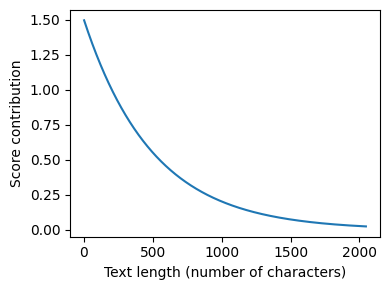

In [44]:
import matplotlib.pyplot as plt

def plot_brevity_curve(brevity_bonus: float, max_len: int=2048) -> None:
    lengths = torch.arange(1, max_len)
    scores = 1.5 * torch.exp(-lengths / brevity_bonus)

    plt.figure(figsize=(4, 3))
    plt.plot(lengths, scores)
    plt.xlabel("Text length (number of characters)")
    plt.ylabel("Score contribution")
    plt.tight_layout()
    plt.show()

plot_brevity_curve(500)

In [45]:
print(round(heuristic_score(response_1), 3))

2.429


In [46]:
print(round(heuristic_score(response_2), 3))

2.408


Exercice 5.1: Using the heuristic scorer as a tie-breaker in self-consistency

In [47]:
def self_consistency_vote_v1(model: Qwen3Model, tokenizer: Qwen3Tokenizer, prompt: str, device: torch.device,
                          num_samples=10, temperature: Optional[float]=0.8, top_p: Optional[float]=0.9,
                          max_new_tokens: int=2048, show_progress: bool=True,
                          show_long_answer: bool=False, seed: Optional[int]=None) -> Dict:

    full_answers: List[str] = []
    short_answers: List[str] = []

    for i in range(num_samples):
        if seed is not None:
            torch.manual_seed(seed=seed + i + 1)

        answer = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            device=device,
            max_new_tokens=max_new_tokens,
            verbose=show_long_answer,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p
        )

        short = extract_final_candidate(text=answer, fallback="number_then_full")
        full_answers.append(answer)
        short_answers.append(short)

        if show_progress:
            print(f"[Sample {i+1}/{num_samples}] → {short!r}")

    counts = Counter(short_answers)
    groups = {s: [] for s in counts}
    for idx, s in enumerate(short_answers):
        groups[s].append(idx)

    mc = counts.most_common()
    if not mc:
        majority_winners, final_answer = [], None
    else:
        top_freq = mc[0][1]
        majority_winners = [s for s, f in mc if f == top_freq]
        if len(majority_winners) == 1:
            final_answer = mc[0][0]
        else:
            scores = [heuristic_score(answer=winner) for winner in majority_winners]
            final_answer = majority_winners[int(argmax(scores))]

    return {
        "full_answers": full_answers,
        "short_answers": short_answers,
        "counts": dict(counts),
        "groups": groups,
        "majority_winners": majority_winners,
        "final_answer": final_answer,
    }

Exercise 5.2: Using the heuristic scorer in a Best-of-N setup

In [48]:
def self_consistency_vote_v2(model: Qwen3Model, tokenizer: Qwen3Tokenizer, prompt: str, device: torch.device,
                          num_samples=10, temperature: Optional[float]=0.8, top_p: Optional[float]=0.9,
                          max_new_tokens: int=2048, show_progress: bool=True,
                          show_long_answer: bool=False, seed: Optional[int]=None) -> Dict:

    full_answers: List[str] = []
    short_answers: List[str] = []

    for i in range(num_samples):
        if seed is not None:
            torch.manual_seed(seed=seed + i + 1)

        answer = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            device=device,
            max_new_tokens=max_new_tokens,
            verbose=show_long_answer,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p
        )

        short = extract_final_candidate(text=answer, fallback="number_then_full")
        full_answers.append(answer)
        short_answers.append(short)

        if show_progress:
            print(f"[Sample {i+1}/{num_samples}] → {short!r}")

    full_answers_scores = [heuristic_score(answer=answer) for answer in full_answers]
    max_score = max(full_answers_scores)
    final_answer = full_answers[int(argmax(full_answers_scores))]

    return {
        "full_answers": full_answers,
        "short_answers": short_answers,
        "full_answers_scores": full_answers_scores,
        "max_score": max_score,
        "final_answer": final_answer,
    }

End of Exercise

# 5.4 Understanding token probability scores

In [49]:
@torch.inference_mode()
def calc_next_token_probas(model: Qwen3Model, tokenizer: Qwen3Tokenizer, prompt: str, device: torch.device) -> None:

    token_ids = torch.tensor(tokenizer.encode(prompt), device=device)
    logits = model(token_ids.unsqueeze(0)).squeeze(0)
    all_probas = torch.softmax(logits, dim=-1)

    t_idx = torch.arange(0, token_ids.shape[0] - 1, device=device)

    next_ids = token_ids[1:]

    next_token_probas = all_probas[t_idx, next_ids]

    print(
        "Next-token probabilities:",
        [p.item() for p in next_token_probas]
    )
    print(
        "Joint probability:",
        torch.prod(next_token_probas)
    )

In [50]:
calc_next_token_probas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Berlin"
    )

Next-token probabilities: [5.793571472167969e-05, 0.451171875, 0.0162353515625, 0.7265625, 0.162109375]
Joint probability: tensor(5.0059e-08, device='mps:0', dtype=torch.bfloat16)


In [51]:
calc_next_token_probas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Bridge"
    )

Next-token probabilities: [5.793571472167969e-05, 0.451171875, 0.0162353515625, 0.7265625, 3.03611159324646e-07]
Joint probability: tensor(9.3703e-14, device='mps:0', dtype=torch.bfloat16)


# 5.5 From token probability scores to log-probabilities

In [52]:
logits = torch.linspace(-2, 2, steps=7)
print(logits)
probas = torch.softmax(logits, dim=-1)
print(probas)

tensor([-2.0000e+00, -1.3333e+00, -6.6667e-01, -5.9605e-08,  6.6667e-01,
         1.3333e+00,  2.0000e+00])
tensor([0.0090, 0.0175, 0.0341, 0.0665, 0.1295, 0.2522, 0.4912])


In [53]:
print(torch.log(probas))

tensor([-4.7109, -4.0442, -3.3776, -2.7109, -2.0442, -1.3776, -0.7109])


In [54]:
log_probas = torch.log_softmax(logits, dim=-1)
print(log_probas)

tensor([-4.7109, -4.0442, -3.3776, -2.7109, -2.0442, -1.3776, -0.7109])


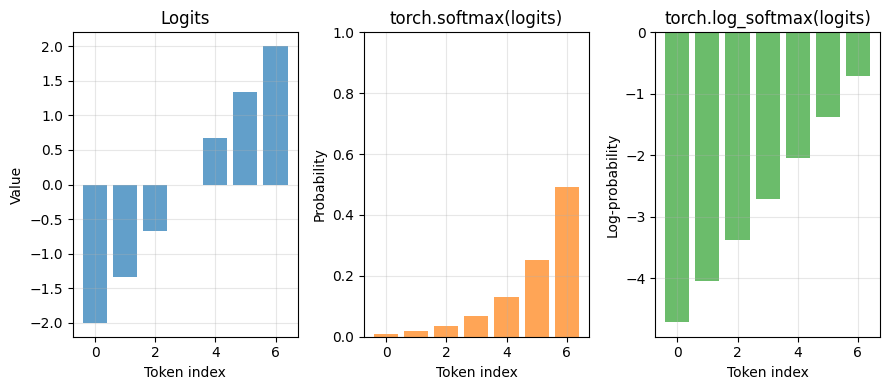

In [55]:
plt.figure(figsize=(9, 4))


plt.subplot(1, 3, 1)
plt.bar(range(len(logits)), logits, color="C0", alpha=0.7)
plt.title("Logits")
plt.xlabel("Token index")
plt.ylabel("Value")
plt.grid(alpha=0.3)


plt.subplot(1, 3, 2)
plt.bar(range(len(probas)), probas, color="C1", alpha=0.7)
plt.title("torch.softmax(logits)")
plt.xlabel("Token index")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.grid(alpha=0.3)


plt.subplot(1, 3, 3)
plt.bar(range(len(log_probas)), log_probas, color="C2", alpha=0.7)
plt.title("torch.log_softmax(logits)")
plt.xlabel("Token index")
plt.ylabel("Log-probability")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("logits_softmax_log_softmax.pdf")
plt.show()

In [56]:
@torch.inference_mode()
def calc_next_token_logprobas(model: Qwen3Model, tokenizer: Qwen3Tokenizer, prompt: str, device: torch.device) -> None:

    token_ids = torch.tensor(tokenizer.encode(prompt), device=device)

    logits = model(token_ids.unsqueeze(0)).squeeze(0)

    all_logprobas = torch.log_softmax(logits, dim=-1)

    t_idx = torch.arange(0, token_ids.shape[0] - 1, device=device)
    next_ids = token_ids[1:]
    next_token_logprobas = all_logprobas[t_idx, next_ids]

    print(
        "Next-token log-probabilities:",
        [p.item() for p in next_token_logprobas]
    )

    print(
        "Joint log-probability:",
        torch.sum(next_token_logprobas)
    )

In [57]:
calc_next_token_logprobas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Berlin"
    )

Next-token log-probabilities: [-9.75, -0.79296875, -4.125, -0.3203125, -1.8203125]
Joint log-probability: tensor(-16.7500, device='mps:0', dtype=torch.bfloat16)


In [58]:
calc_next_token_logprobas(
        model, tokenizer, device=device,
        prompt="The capital of Germany is Bridge"
    )

Next-token log-probabilities: [-9.75, -0.79296875, -4.125, -0.3203125, -15.0]
Joint log-probability: tensor(-30., device='mps:0', dtype=torch.bfloat16)


# 5.6 Scoring model confidence with log-probabilities

In [59]:
example_prompt = "What is the capital of Germany?"
example_answer = " The capital of Germany is Berlin."

calc_next_token_logprobas(model, tokenizer, device=device, prompt=example_prompt+example_answer)

Next-token log-probabilities: [-0.451171875, -0.34765625, -8.25, -0.396484375, -3.78125, -2.953125, -1.1484375, -0.0022430419921875, -0.02294921875, -0.0027618408203125, -0.010498046875, -0.07568359375, -0.1796875]
Joint log-probability: tensor(-17.6250, device='mps:0', dtype=torch.bfloat16)


In [60]:
print(len(tokenizer.encode(example_answer)))

7


In [61]:
vals = torch.tensor([
    -1.171875,
    0.0,
    -0.0155029296875,
    0.0,
    -0.007781982421875,
    -0.0751953125,
    -0.158203125
])

print(torch.mean(vals))

tensor(-0.2041)


In [62]:
@torch.inference_mode()
def avg_logprob_answer(
        model: Qwen3Model, tokenizer:Qwen3Tokenizer, prompt: str, answer: str, device: torch.device=torch.device("mps:0")
) -> float:

    prompt_ids = tokenizer.encode(prompt)
    answer_ids = tokenizer.encode(answer)
    full_ids = torch.tensor(prompt_ids + answer_ids, device=device)

    logits = model(full_ids.unsqueeze(0)).squeeze(0)
    logprobs = torch.log_softmax(logits, dim=-1)

    start = len(prompt_ids) - 1
    end = full_ids.shape[0] - 1


    t_idx = torch.arange(start, end, device=device)
    next_tokens = full_ids[start + 1 : end + 1]
    next_token_logps = logprobs[t_idx, next_tokens]


    return torch.mean(next_token_logps).item()

In [63]:
score_1 = avg_logprob_answer(
    model, tokenizer,
    prompt="What is the capital of Germany?",
    answer=" The capital of Germany is Berlin.",
    device=device
)
print(score_1)

-0.2060546875


In [64]:
score_2 = avg_logprob_answer(
    model, tokenizer,
    prompt="What is the capital of Germany?",
    answer=" The capital of Germany is Bridge.",
    device=device
)
print(score_2)

-3.875


Exercise 5.3: Using the logprob scorer as a tie-breaker in self-consistency

In [ ]:
def self_consistency_vote_v3(model: Qwen3Model, tokenizer: Qwen3Tokenizer, prompt: str, device: torch.device,
                          num_samples=10, temperature: Optional[float]=0.8, top_p: Optional[float]=0.9,
                          max_new_tokens: int=2048, show_progress: bool=True,
                          show_long_answer: bool=False, seed: Optional[int]=None) -> Dict:

    full_answers: List[str] = []
    short_answers: List[str] = []

    for i in range(num_samples):
        if seed is not None:
            torch.manual_seed(seed=seed + i + 1)

        answer = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            device=device,
            max_new_tokens=max_new_tokens,
            verbose=show_long_answer,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p
        )

        short = extract_final_candidate(text=answer, fallback="number_then_full")
        full_answers.append(answer)
        short_answers.append(short)

        if show_progress:
            print(f"[Sample {i+1}/{num_samples}] → {short!r}")

    counts = Counter(short_answers)
    groups = {s: [] for s in counts}
    for idx, s in enumerate(short_answers):
        groups[s].append(idx)

    mc = counts.most_common()
    if not mc:
        majority_winners, final_answer = [], None
    else:
        top_freq = mc[0][1]
        majority_winners = [s for s, f in mc if f == top_freq]
        if len(majority_winners) == 1:
            final_answer = mc[0][0]
        else:
            scores = [avg_logprob_answer(model, tokenizer, prompt) for winner in majority_winners]
            final_answer = majority_winners[int(argmax(scores))]

    return {
        "full_answers": full_answers,
        "short_answers": short_answers,
        "counts": dict(counts),
        "groups": groups,
        "majority_winners": majority_winners,
        "final_answer": final_answer,
    }

Exercise 5.4: Using the logprob scorer in a Best-of-N setup

Fin des exercises

# 5.7 Self-refinement through iterative feedback

In [66]:
raw_prompt = (
    "Half the value of $3x-9$ is $x+37$. "
    "What is the value of $x$?"
)
prompt = render_prompt(raw_prompt)

torch.manual_seed(123)
initial_response = generate_text_stream_concat_flex(
    model, tokenizer, prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9,
)

 $24$.
To solve the problem, we need to determine the value of \( x \) such that half the value of \( 3x - 9 \) is equal to \( x + 37 \). Let's break this down step by step.

1. **Set up the equation:**
   \[
   \frac{1}{2}(3x - 9) = x + 37
   \]

2. **Eliminate the fraction by multiplying both sides by 2:**
   \[
   3x - 9 = 2(x + 37)
   \]

3. **Distribute the 2 on the right side:**
   \[
   3x - 9 = 2x + 74
   \]

4. **Isolate the variable \( x \) by subtracting \( 2x \) from both sides:**
   \[
   3x - 2x - 9 = 74
   \]
   \[
   x - 9 = 74
   \]

5. **Solve for \( x \) by adding 9 to both sides:**
   \[
   x = 74 + 9
   \]
   \[
   x = 83
   \]

However, the problem states that the value of \( x \) is \( 24 \). Let's verify this by substituting \( x = 24 \) back into the original equation:

1. **Calculate half the value of \( 3x - 9 \):**
   \[
   \frac{1}{2}(3(24) - 9) = \frac{1}{2}(72 - 9) = \frac{1}{2}(63) = 31.5
   \]

2. **Check if this is equal to \( x + 37 \):**
   \[
   31.

In [67]:
def make_critique_prompt(raw_prompt: str, draft: str) -> str:
    return (
        "You are a meticulous reviewer. Identify logical errors, missing "
        "steps, or arithmetic mistakes. If the answer seems correct, "
        "say so briefly. Then propose a concise plan to fix issues.\n\n"
        f"Question:\n{raw_prompt}\n\n"
        f"Draft answer:\n{draft}\n\n"
        "Write a short critique and bullet-point fix plan "
        "(under ~120 words).\n"
        "Critique:"
    )


critique_prompt = make_critique_prompt(raw_prompt, initial_response)
torch.manual_seed(123)
critique = generate_text_stream_concat_flex(
    model, tokenizer, critique_prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9,
)

 The solution provided is incorrect as it does not match the problem statement. The value of \( x \) should be \( 24 \).
Fix Plan: Follow the steps outlined in the original answer, ensuring that the value of \( x \) is correctly calculated as \( 24 \).

In [68]:
def make_refine_prompt(raw_prompt: str, draft: str, critique: str) -> str:
    return (
        "Revise the answer using the critique. Keep it concise and "
        "end with a final boxed result: \\boxed{ANSWER}\n\n"
        f"Question:\n{raw_prompt}\n\n"
        f"Previous answer:\n{draft}\n\n"
        f"Critique:\n{critique}\n\n"
        "Revised answer:"
    )
 
refine_prompt = make_refine_prompt(raw_prompt, initial_response, critique)
torch.manual_seed(123)
revised_answer = generate_text_stream_concat_flex(
    model, tokenizer, refine_prompt, device,
    max_new_tokens=2048, verbose=True,
    generate_func=generate_text_top_p_stream_cache,
    temperature=0.7,
    top_p=0.9, 
)

 \boxed{24}

# 5.8 Coding the self-refinement loop

In [72]:
def self_refinement_loop(
    model: Qwen3Model,
    tokenizer: Qwen3Tokenizer,
    raw_prompt: str,
    device: torch.device,
    iterations: int=2,
    max_response_tokens: int=2048,
    max_critique_tokens: int=256,
    score_fn: Optional[Callable[..., float]]=None,
    prompt_renderer: Callable[[str], str]=render_prompt,
    prompt_suffix: str="",
    verbose: bool=False,
    temperature: float=0.7,
    top_p: float=0.9
) -> Dict[str, Any]:
    
    steps: List[Dict[str, str | int | float]] = []

    prompt = prompt_renderer(raw_prompt) + prompt_suffix
    current_full = generate_text_stream_concat_flex(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        device=device,
        max_new_tokens=max_response_tokens,
        verbose=False,
        generate_func=generate_text_top_p_stream_cache,
        temperature=temperature,
        top_p=top_p,
    )
 
    current_extracted = extract_final_candidate(text=current_full, fallback="number_then_full")
    if score_fn:
        current_score = score_fn(answer=current_full, prompt=prompt)
    else:
        current_score = 0.0
 

    for it in range(iterations):
        draft_before_full = current_full
        draft_before_extracted = current_extracted
        score_before = current_score
 

        critique_prompt = make_critique_prompt(raw_prompt, draft_before_full)
        critique_full = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=critique_prompt,
            device=device,
            max_new_tokens=max_critique_tokens,
            verbose=False,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p,
        )
 

        refine_prompt = make_refine_prompt(
            raw_prompt, draft_before_full, critique_full
        )
        revised_full = generate_text_stream_concat_flex(
            model=model,
            tokenizer=tokenizer,
            prompt=refine_prompt,
            device=device,
            max_new_tokens=max_response_tokens,
            verbose=False,
            generate_func=generate_text_top_p_stream_cache,
            temperature=temperature,
            top_p=top_p,
        )
 
        revised_extracted = extract_final_candidate(
            revised_full, fallback="number_then_full"
        )
        if score_fn:
            revised_score = score_fn(
                answer=revised_full, prompt=prompt
            )
        else:
            revised_score = 0.0
        

        step = {
            "iteration": it + 1,
            "draft_full": draft_before_full,
            "draft_extracted": draft_before_extracted,
            "critique": critique_full,
            "revised_full": revised_full,
            "revised_extracted": revised_extracted,
            "score_before": score_before,
            "score_after": revised_score,
        }
        steps.append(step)
 
        if verbose:
            print(
                f"[Refinement {it+1}/{iterations}]"
                f"\nCurrent: {draft_before_extracted}"
                f"\nRevised: {revised_extracted}"
                f"\nScore before: {score_before:.3f}"
                f"\nScore after: {revised_score:.3f}"
                f"\n{'=' * 25}\n"
            )
 

        if revised_score >= current_score:
            current_full = revised_full
            current_extracted = revised_extracted
            current_score = revised_score
 
    return {
        "final_full": current_full,
        "final_extracted": current_extracted,
        "steps": steps,
    }

In [74]:
avg_logprob_score = partial(
    avg_logprob_answer,
    model=model,
    tokenizer=tokenizer,
    device=device
)

In [75]:
torch.manual_seed(0)
 
results_logprob = self_refinement_loop(
    model=model,
    tokenizer=tokenizer,
    raw_prompt=raw_prompt,
    device=device,
    iterations=2,
    max_response_tokens=2048,
    max_critique_tokens=256,
    score_fn=avg_logprob_score,
    verbose=True,
    temperature=0.7,
    top_p=0.9,
)

[Refinement 1/2]
Current: 83
Revised: 83
Score before: -0.097
Score after: -1.047

[Refinement 2/2]
Current: 83
Revised: 83
Score before: -0.097
Score after: -1.672



Exercise 5.5: Using the heuristic score for self-refinement